# Project XOR

William Black

### To run

We assume you already have TensorFlow installed in your current Python environment. Suppose the project directory is `~/my/proj/`. 

1. Depending on whether you have a GPU in your machine or not, you will type `conda env create -f ~/my/proj/environment-gpu.yml` or `conda env create -f ~/my/proj/environment-cpu.yml` into terminal.

1. Depending on whether you have a GPU in your machine or not, you will type `conda env activate proj_xor_gpu` or `conda env activate proj_xor_gpu` into terminal.

1. Enter `conda develop ~/my/proj/` into terminal. This will allow Conda to see your project by adding it to the Python Path.

1. Restart the current Python kernel and reopen this Jupyter Notebook with the virtual environment from step 2 activated. 

In [1]:
from IPython import display
from importlib_resources import files
from pandas import read_csv
from proj_xor.__main__ import main

2023-02-11 22:44:17.936041: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-11 22:44:18.002417: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-11 22:44:18.339960: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-11 22:44:18.339992: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

## Main Method

You can rerun this `main()` method to retrain the model and regenerate the outputs.

In [2]:
main()

2023-02-11 22:44:19.011096: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 22:44:19.027589: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-02-11 22:44:19.027612: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-02-11 22:44:19.028406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

  0%|          | 0/60 [00:00<?, ?it/s]

Epoch   0	Train Loss: 0.74177176	Train Accuracy: 56.05000305	Test Loss: 0.71647561	Test Accuracy: 50.00000000
Epoch   5	Train Loss: 0.57820582	Train Accuracy: 74.50000000	Test Loss: 0.52246505	Test Accuracy: 71.00000000
Epoch  10	Train Loss: 0.28565708	Train Accuracy: 97.89999390	Test Loss: 0.25943315	Test Accuracy: 99.00000000
Epoch  15	Train Loss: 0.16993402	Train Accuracy: 99.90000153	Test Loss: 0.15984094	Test Accuracy: 100.00000000
Epoch  20	Train Loss: 0.11017890	Train Accuracy: 100.00000000	Test Loss: 0.10471316	Test Accuracy: 100.00000000
Epoch  25	Train Loss: 0.07514250	Train Accuracy: 100.00000000	Test Loss: 0.07198244	Test Accuracy: 100.00000000
Epoch  30	Train Loss: 0.05380993	Train Accuracy: 100.00000000	Test Loss: 0.05180289	Test Accuracy: 100.00000000
Epoch  35	Train Loss: 0.04039405	Train Accuracy: 100.00000000	Test Loss: 0.03902643	Test Accuracy: 100.00000000
Epoch  40	Train Loss: 0.03166060	Train Accuracy: 100.00000000	Test Loss: 0.03066594	Test Accuracy: 100.00000000

Below is the code for `main()`

In [3]:
display.Code(files("proj_xor").joinpath("__main__.py"))

import logging
from proj_xor.models import ProjXORWrapper
from proj_xor.plots import plot_data

def main(logging_level=logging.WARNING):
    logging.basicConfig(level=logging_level)
    logging.info("Entering main method.")

    M = ProjXORWrapper()

    M.fit(
        save_plots=True,
        show_plots=False,
        save_dfs=True,
        show_dfs=False,
        monitor_freq=5,
    )

    plot_data.plot_model_performance(M.get_model(), show_plt=False)

    logging.info("Exiting main method.")


if __name__ == "__main__":
    main(logging_level=logging.INFO)

## The Model

Below is the code that makes up the model as well as a wrapper class for convenience

In [4]:
display.Code(files("proj_xor").joinpath("models.py"))

import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

from tensorflow.keras.losses import BinaryCrossentropy as BinaryCrossentropyLoss
from tensorflow.keras.metrics import (
    BinaryCrossentropy as BinaryCrossentropyMetric,
    BinaryAccuracy,
)
from tensorflow.keras.optimizers.experimental import Nadam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import pandas as pd
from importlib_resources import files

from tqdm.auto import trange, tqdm

from proj_xor.data import get_data
from proj_xor.plots.plot_metrics import plot_loss, plot_accuracy


class ProjXORModel(Model):
    def __init__(
        self,
        loss=None,
        optimizer=None,
        optimizer_schedule=None,
        train_loss_metric=None,
        test_loss_metric=None,
        train_acc_metric=None,
        test_acc_metric=None,
        layers=None,
    ):
        super(ProjXORModel, self).__init__()

        if layers is None:
            self._layers = [
                Dense(2, activation="swish"),
                Dense(1, activation="sigmoid"),
            ]
        else:
            self._layers = layers

        if loss is None:
            self.loss_object = BinaryCrossentropyLoss(from_logits=False)
        else:
            self.loss_object = loss

        if optimizer_schedule is None:
            self._optimizer_schedule = ExponentialDecay(
                2,
                decay_steps=10 ** 2,
                decay_rate=0.8,
                name="exponential_decay_schedule",
            )
        else:
            self._optimizer_schedule = optimizer_schedule
        if optimizer is None:
            self._optimizer = Nadam(
                learning_rate=self._optimizer_schedule,
                name="nadam_optimizer",
            )
        else:
            self._optimizer = optimizer

        if train_loss_metric is None:
            self.train_loss = BinaryCrossentropyMetric(name="train_loss")
        else:
            self.train_loss = train_loss_metric
        if train_acc_metric is None:
            self.train_accuracy = BinaryAccuracy(name="train_accuracy")
        else:
            self.train_accuracy = train_acc_metric

        if test_loss_metric is None:
            self.test_loss = BinaryCrossentropyMetric(name="test_loss")
        else:
            self.test_loss = test_loss_metric
        if test_acc_metric is None:
            self.test_accuracy = BinaryAccuracy(name="test_accuracy")
        else:
            self.test_accuracy = test_acc_metric

    def call(self, x):
        for f in self._layers:
            x = f(x)
        return x


class ProjXORWrapper:
    def __init__(
        self,
        loss=None,
        optimizer=None,
        optimizer_schedule=None,
        train_loss_metric=None,
        test_loss_metric=None,
        train_acc_metric=None,
        test_acc_metric=None,
        layers=None,
        epochs=60,
        batch_size=50,
    ):
        ## I know this function has a lot of repeated code, but fixing it is not a priority
        self._is_fitted = False

        self._epochs = epochs
        self._batch_size = batch_size

        if layers is None:
            self._layers = [
                Dense(2, activation="swish"),
                # swish works much better than relu or sigmoid
                Dense(1, activation="sigmoid"),
            ]
        else:
            self._layers = layers

        if loss is None:
            self.loss_object = BinaryCrossentropyLoss(from_logits=False)
        else:
            self.loss_object = loss

        if optimizer_schedule is None:
            self._optimizer_schedule = ExponentialDecay(
                0.5,
                decay_steps=10 ** 2,
                decay_rate=0.9,
                name="exponential_decay_schedule",
            )
        else:
            self._optimizer_schedule = optimizer_schedule
        if optimizer is None:
            self._optimizer = Nada

## Loss and Accuracy

### Loss

Below is the plot of the loss as well as the associated table of data.

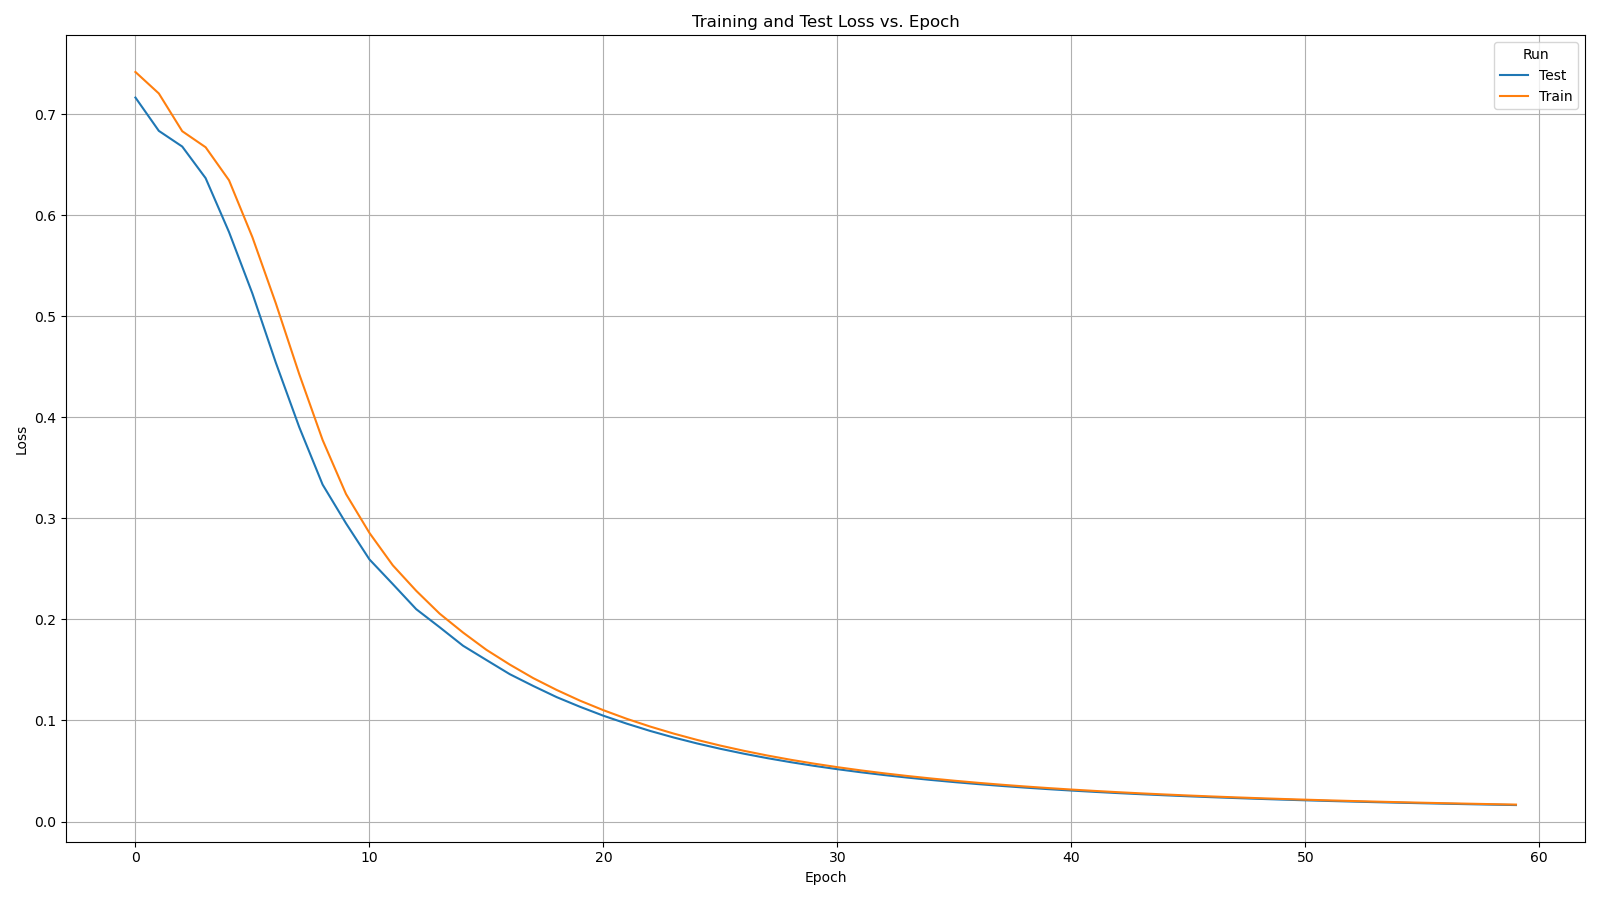

In [5]:
display.Image(files("proj_xor.plots.metrics").joinpath("loss.png"))

In [6]:
display.display(read_csv(files("proj_xor.data.outputs").joinpath("loss.csv")))

,epoch,run,val
0,0,test,0.716476
1,1,test,0.683503
2,2,test,0.667983
3,3,test,0.636705
4,4,test,0.583345
...,...,...,...
115,55,train,0.018628
116,56,train,0.018125
117,57,train,0.017649
118,58,train,0.017197


### Accuracy

Below is the plot of the accuracy as well as the associated table of data.

In [7]:
display.display(read_csv(files("proj_xor.data.outputs").joinpath("accuracy.csv")))

,epoch,run,val
0,0,test,0.50
1,1,test,0.56
2,2,test,0.71
3,3,test,0.71
4,4,test,0.74
...,...,...,...
115,55,train,1.00
116,56,train,1.00
117,57,train,1.00
118,58,train,1.00


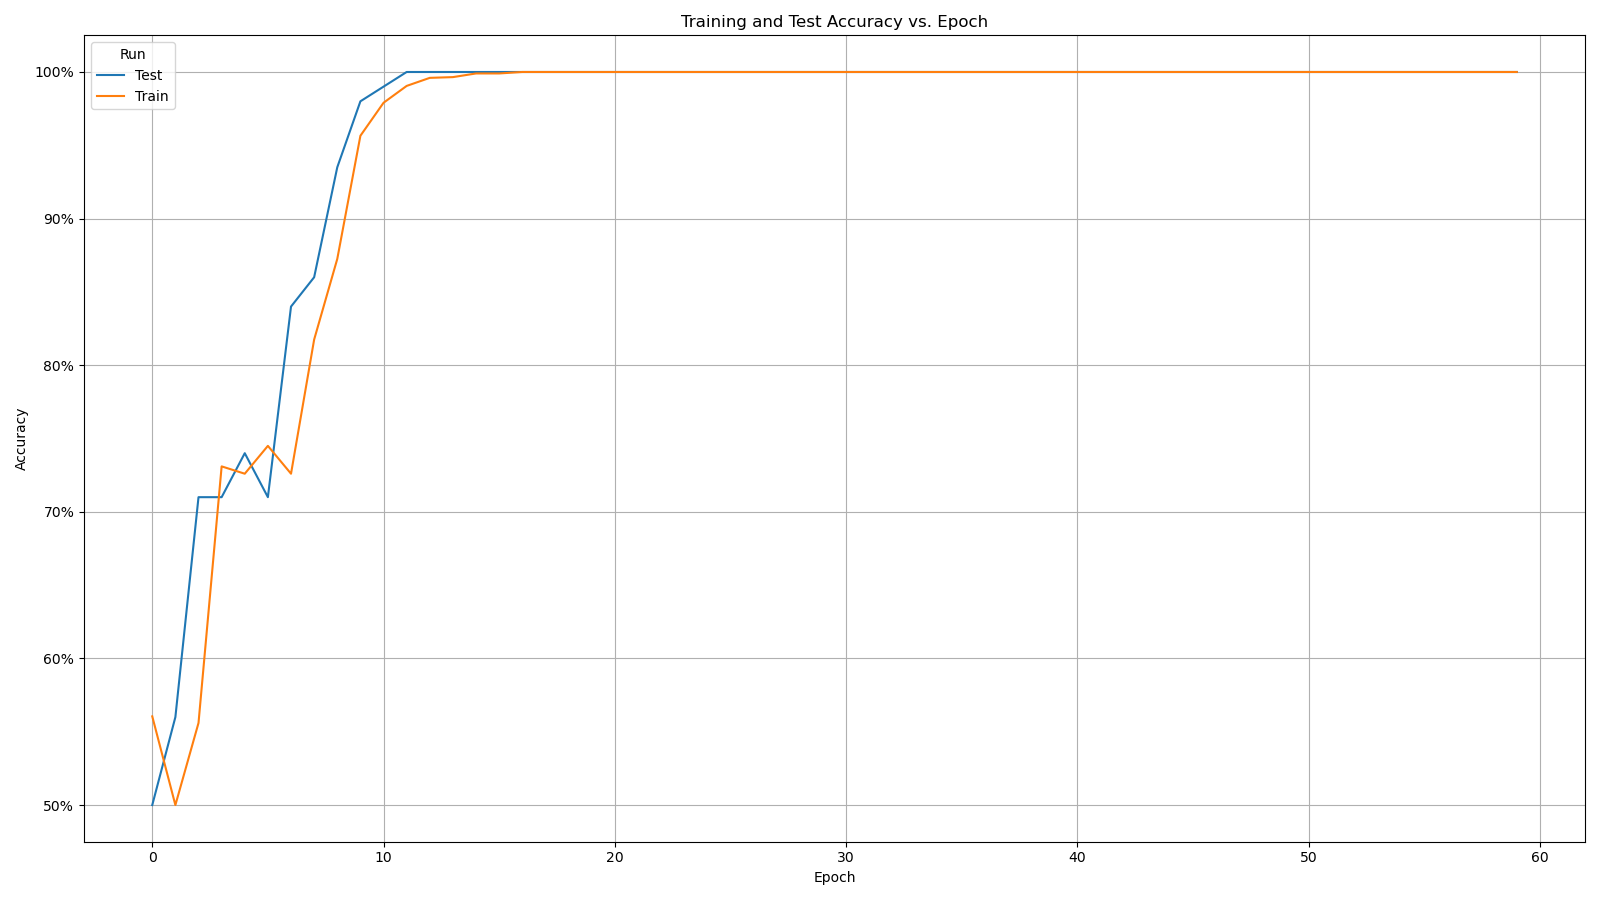

In [8]:
display.Image(files("proj_xor.plots.metrics").joinpath("accuracy.png"))

### Plotting Code

The below code was used to generate the loss and accuracy plots.

In [9]:
display.Code(files("proj_xor.plots").joinpath("plot_metrics.py"))

import seaborn as sns
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
from importlib_resources import files

_plot_path = files("proj_xor.plots.metrics")


def plot_loss(loss_df, save_plt=True, show_plt=False, fname=None):
    if not (save_plt or show_plt):
        return
    loss_df["run"] = loss_df["run"].replace(["test"], "Test")
    loss_df["run"] = loss_df["run"].replace(["train"], "Train")
    loss_df = loss_df.set_axis(["Epoch", "Run", "Loss"], axis='columns')

    plt.figure(figsize=(16, 9))
    plot = sns.lineplot(
        data=loss_df,
        x="Epoch",
        y="Loss",
        hue="Run",
    )

    plt.title("Training and Test Loss vs. Epoch") 
    plt.grid()
    plt.tight_layout()

    if save_plt:
        if fname is None:
            fname = "loss.png"
        plt.savefig(_plot_path.joinpath(fname))
    if show_plt:
        plt.show()
    plt.close()


def plot_accuracy(acc_df, save_plt=True, show_plt=False, fname=None):
    if not (save_plt or show_plt):
        return
    acc_df["run"] = acc_df["run"].replace(["test"], "Test")
    acc_df["run"] = acc_df["run"].replace(["train"], "Train")
    acc_df = acc_df.set_axis(["Epoch", "Run", "Accuracy"], axis='columns')

    plt.figure(figsize=(16, 9))
    plot = sns.lineplot(
        data=acc_df,
        x="Epoch",
        y="Accuracy",
        hue="Run",
    )
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.title("Training and Test Accuracy vs. Epoch")
    plt.grid()
    plt.tight_layout()

    if save_plt:
        if fname is None:
            fname = "accuracy.png"
        plt.savefig(_plot_path.joinpath(fname))
    if show_plt:
        plt.show()
    plt.close()

## Test Performance

Below is a visualization of the model's performance on the test data with the code used to generate it.

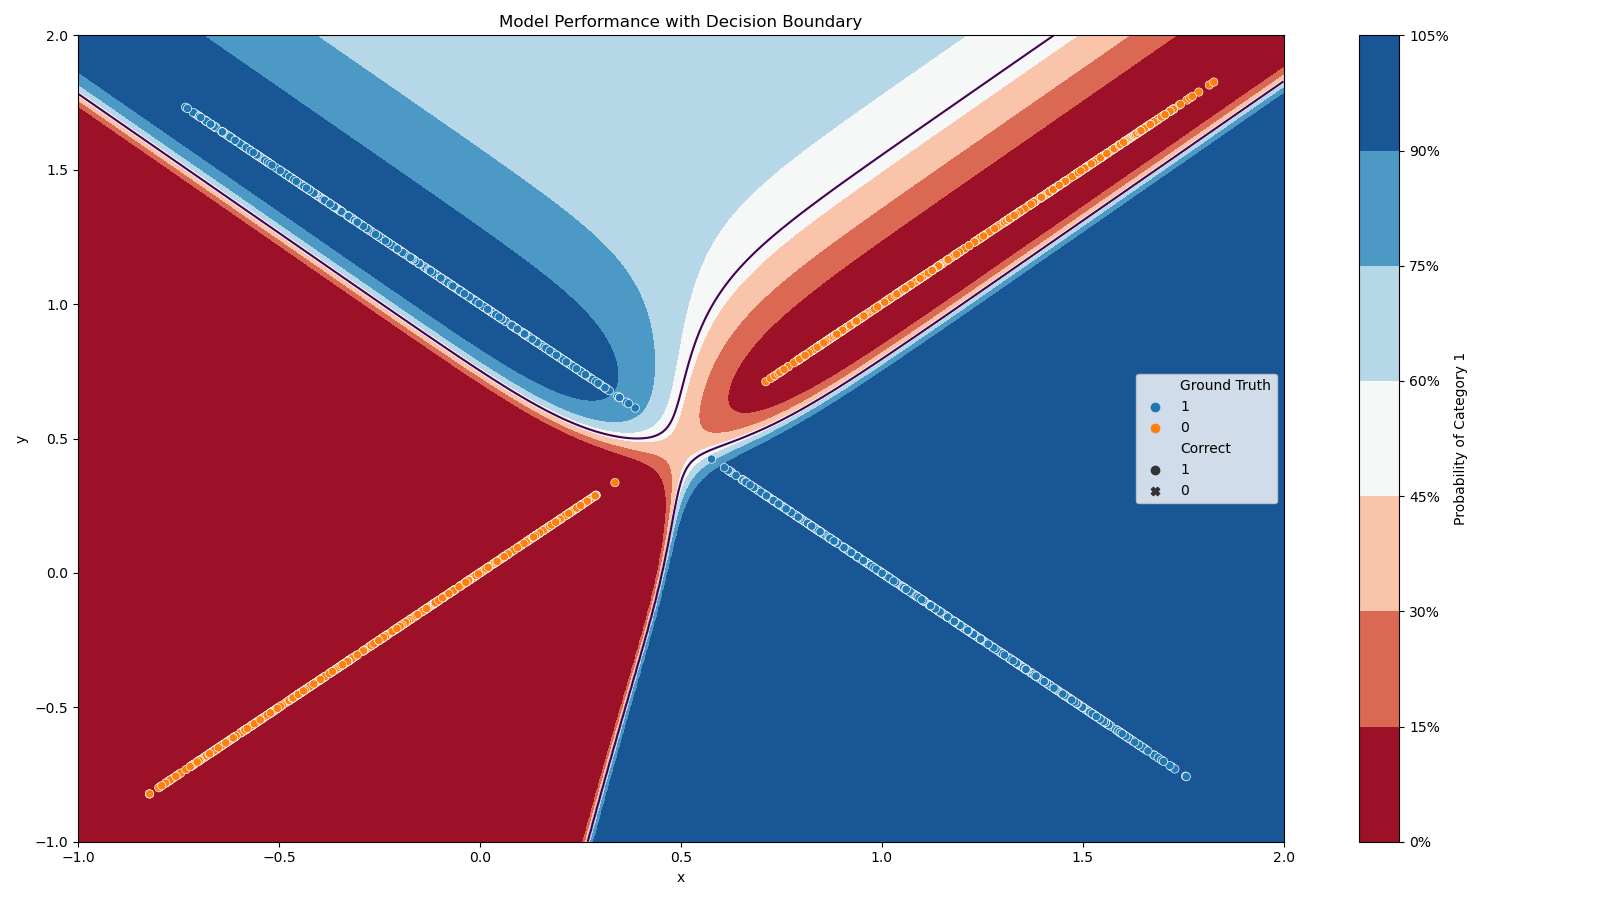

In [10]:
display.Image(files("proj_xor.plots.data").joinpath("performance.png"))

In [11]:
display.Code(files("proj_xor.plots").joinpath("plot_data.py"))

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from importlib_resources import files
import tensorflow as tf
import pandas as pd
import numpy as np
from proj_xor.data import get_data


_plot_path = files("proj_xor.plots.data")
_dataset_path = files("proj_xor.data.datasets")


def plot_model_performance(model, save_plt=True, show_plt=False, fname=None):
    for data, labels in get_data.train_data():
        labels = tf.cast(tf.reshape(labels, (-1, 1)), tf.dtypes.uint8)
        pred = tf.cast(model(data) > 0.5, tf.dtypes.uint8)

    df = pd.DataFrame(
        data={
            "x": data[:, 0],
            "y": data[:, 1],
            "Ground Truth": pd.Series(tf.reshape(labels, (-1,))),
            "Prediction": pd.Series(tf.reshape(pred, (-1,))),
            "Correct": pd.Series(tf.reshape(labels == pred, (-1,)), dtype=int),
        },
    )

    plt.figure(figsize=(16, 9))

    xlim = (-1, 2)
    ylim = (-1, 2)
    N_h_gridpoints = 100 * (xlim[1] - xlim[0])
    N_v_gridpoints = 100 * (ylim[1] - ylim[0])

    hmesh = np.linspace(*xlim, num=N_h_gridpoints)
    vmesh = np.linspace(*ylim, num=N_v_gridpoints)

    xgrid, ygrid = np.meshgrid(hmesh, vmesh)

    onehotx, onehoty = xgrid.reshape((-1, 1)), ygrid.reshape((-1, 1))

    onehotgrid = np.hstack((onehotx, onehoty))

    onehotgridpred = model(onehotgrid)

    gridpred = tf.reshape(onehotgridpred, xgrid.shape)

    cf = plt.contourf(
        xgrid,
        ygrid,
        gridpred,
        cmap="RdBu",
    )
    plt.colorbar(
        cf,
        label="Probability of Category 1",
        spacing="proportional",
        format=PercentFormatter(xmax=1),
    )

    plt.contour(
        xgrid,
        ygrid,
        gridpred,
        levels=[0.5],
    )

    sns.scatterplot(
        data=df,
        x="x",
        y="y",
        hue="Ground Truth",
        hue_order=[1, 0],
        style="Correct",
        style_order=[1, 0],
    )

    plt.title("Model Performance with Decision Boundary")
    plt.legend(loc="center right")
    plt.tight_layout()

    if save_plt:
        if fname is None:
            fname = "performance.png"
        plt.savefig(_plot_path.joinpath(fname))
    if show_plt:
        plt.show()

    plt.close()